In [30]:
import pandas as pd
from pycirclize import Circos
from pycirclize.parser import Matrix

from pathlib import Path

import sys

sys.path.append("../scripts")

from shared import IVY_COLORS
from lcc import LCC_CLASSIFICATION, LCC_TO_AREA, LCC_TOP_CLASSIFICATION

In [31]:
df = pd.read_csv("../data/derived/all_records.csv")
df.head()

,Date,System,From,To,OriginLocation,DestinationLocation,Type,CallNumber
0,2023-09-17 22:54:42 UTC,BorrowDirect,University of Chicago,Dartmouth College,Social Work Library,Baker-Berry,Non-article,E185.86.H379 2019
1,2023-09-17 22:54:42 UTC,BorrowDirect,Cornell University,Dartmouth College,Olin Library,Baker-Berry,Non-article,E185.86 .H379 2019
2,2023-12-11 13:49:24 UTC,BorrowDirect,Yale University,Dartmouth College,"SML, Stacks, LC Classification",Baker-Berry,Non-article,BV823 .C627X 2014 (LC)
3,2023-12-30 23:03:49 UTC,BorrowDirect,Duke University,Dartmouth College,Perkins/Bostock Library,Baker-Berry,Non-article,DE1 .S7833 v.1-4
4,2023-12-29 20:12:26 UTC,BorrowDirect,University of Chicago,Dartmouth College,Regenstein,Baker-Berry,Non-article,HQ1064.U5 M395 1997


In [32]:
link_cmap = []
for partner, color in IVY_COLORS.items():
    link_cmap.append(("Dartmouth College", partner, color))

In [33]:
institutions = [
    "Brown University",
    "Columbia University Libraries",
    "Cornell University",
    "Duke University",
    "Harvard University",
    "Johns Hopkins University",
    "Massachusetts Institute of Technology",
    "Princeton University",
    "Stanford University",
    "University of Pennsylvania",
    "University of Chicago",
    "Yale University",
]

In [34]:
def make_chord(df: pd.DataFrame, order):
    matrix = Matrix.parse_fromto_table(df)
    circos = Circos.initialize_from_matrix(
        matrix,
        start=-265,
        end=95,
        space=5,
        r_lim=(93, 100),
        cmap=IVY_COLORS,
        link_cmap=link_cmap,
        order=order,
        label_kws=dict(
            size=8, color="black", adjust_rotation=True, orientation="vertical"
        ),
        link_kws=dict(ec="black", lw=0.5, direction=1),
    )
    fig = circos.plotfig()
    return fig

## Clean call numbers


In [35]:
df = df.dropna(subset="CallNumber")

df = df[df.CallNumber.apply(lambda x: x[:2].isupper())]

In [36]:
def get_class(lcc: str) -> str:
    return LCC_TOP_CLASSIFICATION.get(lcc[0])


def get_area(lcc: str) -> str:
    return LCC_TO_AREA.get(lcc[0])


def get_subclass(lcc: str) -> str:
    if lcc[:2].isalpha():
        return LCC_CLASSIFICATION.get(lcc[:2])
    if lcc[0].isalpha():
        return LCC_CLASSIFICATION.get(lcc[0])
    return None


df["Area"] = df.CallNumber.apply(get_area)
df["Class"] = df.CallNumber.apply(get_class)
df["Subclass"] = df.CallNumber.apply(get_subclass)
df = df.dropna(subset="Subclass")
df = df[df.Area != "Reference Works"]

In [37]:
# Build categories
areas_to_merge = {
    "Language and Literature": "Humanities",
}
categories = {
    "Medicine": {
        "Medicine and Public Health": [
            {"name": "Public aspects of medicine", "type": "Subclass"},
            {"name": "Medicine (General)", "type": "Subclass"},
        ],
        "Pharmacology": [
            {"name": "Therapeutics. Pharmacology", "type": "Subclass"},
            {"name": "Pharmacy and materia medica", "type": "Subclass"},
        ],
        "Specialty Care": [
            {"name": "Dermatology", "type": "Subclass"},
            {"name": "Gynecology and obstetrics", "type": "Subclass"},
            {"name": "Ophthalmology", "type": "Subclass"},
            {"name": "Otorhinolaryngology", "type": "Subclass"},
            {"name": "Pathology", "type": "Subclass"},
            {"name": "Surgery", "type": "Subclass"},
        ],
        "General Care": [
            {"name": "Dentistry", "type": "Subclass"},
            {"name": "Internal medicine", "type": "Subclass"},
            {"name": "Nursing", "type": "Subclass"},
            {"name": "Pediatrics", "type": "Subclass"},
        ],
    },
    "Music and Arts": {
        "Fine Arts": [
            {"name": "Fine Arts", "type": "Subclass"},
            {"name": "Painting", "type": "Subclass"},
            {"name": "Sculpture", "type": "Subclass"},
            {"name": "Drawing, Design", "type": "Subclass"},
            {"name": "Print Media", "type": "Subclass"},
        ],
        "Architecture": [
            {"name": "Architecture", "type": "Subclass"},
        ],
        "Performing Arts": [
            {"name": "Music and Books on Music", "type": "Class"},
        ],
        "Applied Arts": [
            {"name": "Decorative Arts", "type": "Subclass"},
            {"name": "Arts in general", "type": "Subclass"},
        ],
    },
    "STEM": {
        "Physical Sciences": [
            {"name": "Astronomy", "type": "Subclass"},
            {"name": "Chemistry", "type": "Subclass"},
            {"name": "Geology", "type": "Subclass"},
            {"name": "Physics", "type": "Subclass"},
        ],
        "Life Sciences": [
            {"name": "Botany", "type": "Subclass"},
            {"name": "Human anatomy", "type": "Subclass"},
            {"name": "Natural history. Biology", "type": "Subclass"},
            {"name": "Physiology", "type": "Subclass"},
            {"name": "Microbiology", "type": "Subclass"},
            {"name": "Zoology", "type": "Subclass"},
        ],
        "Applied Sciences and Engineering": [
            {"name": "Technology", "type": "Class"},
            {"name": "Agriculture", "type": "Class"},
            {"name": "Naval Science", "type": "Class"},
            {"name": "Military Science", "type": "Class"},
        ],
        "General Science and Mathematics": [
            {"name": "Science (General)", "type": "Subclass"},
            {"name": "Mathematics", "type": "Subclass"},
        ],
    },
    "Social Sciences": {
        "Information Science and Education": [
            {
                "name": "Bibliography. Library Science. Information Resources (General)",
                "type": "Class",
            },
            {"name": "Education", "type": "Class"},
        ],
        "Government and Law": [
            {"name": "Law", "type": "Class"},
            {"name": "Political Science", "type": "Class"},
        ],
        "Business, Economics and Sociology": [
            {"name": "Social Sciences", "type": "Class"},
        ],
        "Geography, Anthropology, Recreation": [
            {"name": "Geography, Anthropology, Recreation", "type": "Subclass"},
        ],
    },
    "Humanities": {
        "Language and Literature": [
            {"name": "Language and Literature", "type": "Class"},
        ],
        "World History": [
            {"name": "World History", "type": "Class"},
            {
                "name": "History of the Americas",
                "type": "Class",
            },
        ],
        "Philosophy, Psychology, Religion": [],
        "Archaeology, Genealogy, and Biography": [
            {"name": "Auxiliary Sciences of History", "type": "Class"},
        ],
    },
}


for from_area, to_area in areas_to_merge.items():
    df.loc[df.Area == from_area, "Area"] = to_area

for area, mapping in categories.items():
    for new_class, old_items in mapping.items():
        for old_item in old_items:
            df.loc[
                (df.Area == area) & (df[old_item["type"]] == old_item["name"]), "Class"
            ] = new_class

In [38]:
# Break down some very broad classes into subclasses
USE_SUBCLASS = {
    "Humanities": [],
    "Language and Literature": [],
    "Medicine": [],
    "Music and Arts": [],
    "Reference Works:": [],
    "STEM": [],
    "Social Sciences": [],
}

df["GroupingVar"] = df["Class"]
for area, classes in USE_SUBCLASS.items():
    for class_ in classes:
        df.loc[(df.Area == area) & (df.Class == class_), "GroupingVar"] = df.loc[
            (df.Area == area) & (df.Class == class_), "Subclass"
        ]

In [39]:
borrowed = (
    df[(df.To == "Dartmouth College")]
    .groupby(["From", "Area", "GroupingVar"])
    .size()
    .rename("N")
    .reset_index()
    .rename(columns={"GroupingVar": "To"})
)

borrowed

,From,Area,To,N
0,Brown University,Humanities,"Archaeology, Genealogy, and Biography",4
1,Brown University,Humanities,Language and Literature,81
2,Brown University,Humanities,"Philosophy, Psychology, Religion",57
3,Brown University,Humanities,World History,80
4,Brown University,Medicine,General Care,3
...,...,...,...,...
219,Yale University,STEM,Physical Sciences,1
220,Yale University,Social Sciences,"Business, Economics and Sociology",66
221,Yale University,Social Sciences,"Geography, Anthropology, Recreation",20
222,Yale University,Social Sciences,Government and Law,33


In [40]:
quartiles = borrowed["N"].quantile(q=[0.25, 0.5, 0.75]).to_list()

print(f"{quartiles = }")


def get_quartile_idx(N):
    if N <= quartiles[0]:
        return 1
    if N <= quartiles[1]:
        return 2
    if N <= quartiles[2]:
        return 3
    if N > quartiles[2]:
        return 4


borrowed["Quartile"] = borrowed["N"].apply(get_quartile_idx)

quartiles = [3.0, 8.0, 27.0]


In [41]:
borrowed["Rank"] = (
    borrowed.groupby(["From", "Area"])["N"].rank(ascending=False).astype("int")
)
borrowed

,From,Area,To,N,Quartile,Rank
0,Brown University,Humanities,"Archaeology, Genealogy, and Biography",4,2,4
1,Brown University,Humanities,Language and Literature,81,4,1
2,Brown University,Humanities,"Philosophy, Psychology, Religion",57,4,3
3,Brown University,Humanities,World History,80,4,2
4,Brown University,Medicine,General Care,3,1,1
...,...,...,...,...,...,...
219,Yale University,STEM,Physical Sciences,1,1,4
220,Yale University,Social Sciences,"Business, Economics and Sociology",66,4,1
221,Yale University,Social Sciences,"Geography, Anthropology, Recreation",20,3,3
222,Yale University,Social Sciences,Government and Law,33,4,2


In [42]:
borrowed = borrowed[["From", "Area", "To", "N", "Quartile", "Rank"]].sort_values(
    by="From"
)
borrowed

,From,Area,To,N,Quartile,Rank
0,Brown University,Humanities,"Archaeology, Genealogy, and Biography",4,2,4
17,Brown University,Social Sciences,Information Science and Education,8,2,4
16,Brown University,Social Sciences,Government and Law,37,4,2
15,Brown University,Social Sciences,"Geography, Anthropology, Recreation",11,3,3
14,Brown University,Social Sciences,"Business, Economics and Sociology",50,4,1
...,...,...,...,...,...,...
206,Yale University,Humanities,Language and Literature,127,4,1
205,Yale University,Humanities,"Archaeology, Genealogy, and Biography",10,3,4
222,Yale University,Social Sciences,Government and Law,33,4,2
213,Yale University,Music and Arts,Architecture,5,2,3


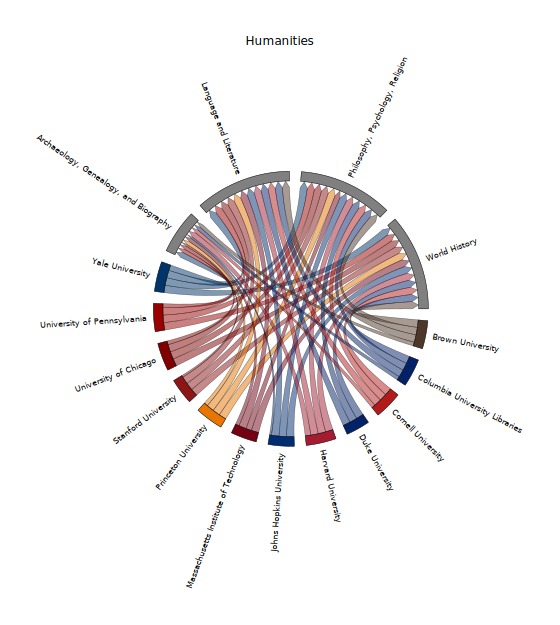

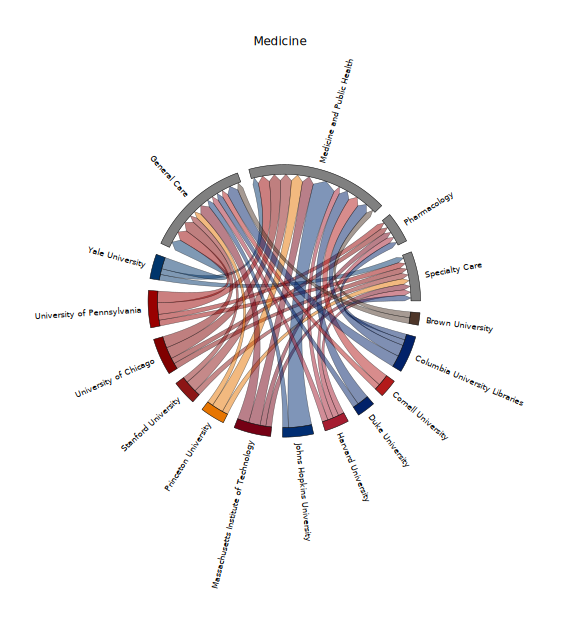

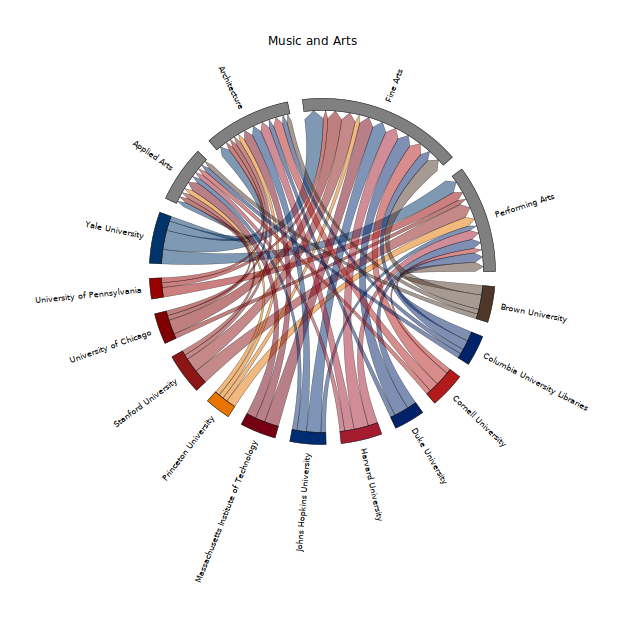

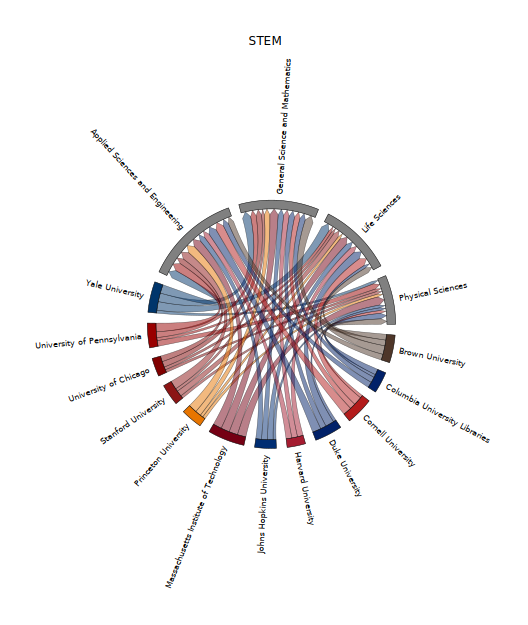

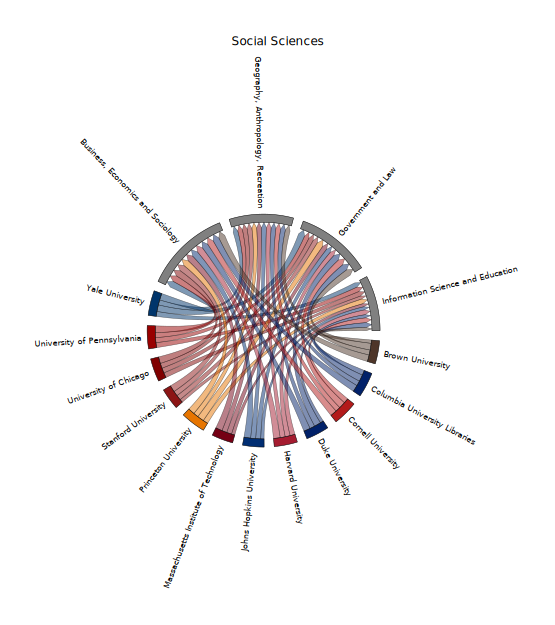

In [43]:
for area, records in borrowed.groupby("Area"):
    order = sorted(records.From.unique()) + sorted(records.To.unique())
    fig = make_chord(records.drop(columns=["Area", "N", "Rank"]), order=order)
    fig.savefig(f"out/chord-borrowed-{area}.png", dpi=300)
    records.to_csv(f"out/borrowed-{area}.csv", index=None)
    fig.suptitle(area)

In [44]:
lent = (
    df[(df.From == "Dartmouth College")]
    .groupby(["To", "Area", "GroupingVar"])
    .size()
    .rename("N")
    .reset_index()
)
lent = lent.rename(columns={"GroupingVar": "From"})
lent = lent[["From", "Area", "To", "N"]]
lent

,From,Area,To,N
0,"Archaeology, Genealogy, and Biography",Humanities,Brown University,5
1,Language and Literature,Humanities,Brown University,142
2,"Philosophy, Psychology, Religion",Humanities,Brown University,54
3,World History,Humanities,Brown University,69
4,General Care,Medicine,Brown University,3
...,...,...,...,...
224,Physical Sciences,STEM,Yale University,24
225,"Business, Economics and Sociology",Social Sciences,Yale University,150
226,"Geography, Anthropology, Recreation",Social Sciences,Yale University,44
227,Government and Law,Social Sciences,Yale University,66


In [45]:
quartiles = lent["N"].quantile(q=[0.25, 0.5, 0.75]).to_list()

print(f"{quartiles = }")


def get_quartile_idx(N):
    if N <= quartiles[0]:
        return 1
    if N <= quartiles[1]:
        return 2
    if N <= quartiles[2]:
        return 3
    if N > quartiles[2]:
        return 4


lent["Quartile"] = lent["N"].apply(get_quartile_idx)

quartiles = [8.0, 18.0, 51.0]


In [46]:
lent["Rank"] = lent.groupby(["To", "Area"])["N"].rank(ascending=False).astype("int")
lent

,From,Area,To,N,Quartile,Rank
0,"Archaeology, Genealogy, and Biography",Humanities,Brown University,5,1,4
1,Language and Literature,Humanities,Brown University,142,4,1
2,"Philosophy, Psychology, Religion",Humanities,Brown University,54,4,3
3,World History,Humanities,Brown University,69,4,2
4,General Care,Medicine,Brown University,3,1,2
...,...,...,...,...,...,...
224,Physical Sciences,STEM,Yale University,24,3,4
225,"Business, Economics and Sociology",Social Sciences,Yale University,150,4,1
226,"Geography, Anthropology, Recreation",Social Sciences,Yale University,44,3,3
227,Government and Law,Social Sciences,Yale University,66,4,2


In [47]:
lent = lent[["From", "Area", "To", "N", "Quartile", "Rank"]].sort_values(by="To")
lent

,From,Area,To,N,Quartile,Rank
0,"Archaeology, Genealogy, and Biography",Humanities,Brown University,5,1,4
19,Information Science and Education,Social Sciences,Brown University,4,1,4
18,Government and Law,Social Sciences,Brown University,19,3,2
17,"Geography, Anthropology, Recreation",Social Sciences,Brown University,15,2,3
16,"Business, Economics and Sociology",Social Sciences,Brown University,50,3,1
...,...,...,...,...,...,...
210,Language and Literature,Humanities,Yale University,375,4,1
209,"Archaeology, Genealogy, and Biography",Humanities,Yale University,11,2,4
227,Government and Law,Social Sciences,Yale University,66,4,2
217,Applied Arts,Music and Arts,Yale University,12,2,4


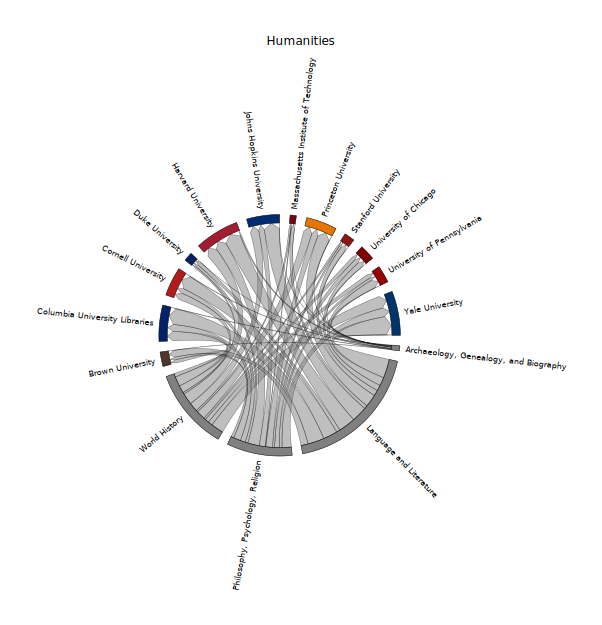

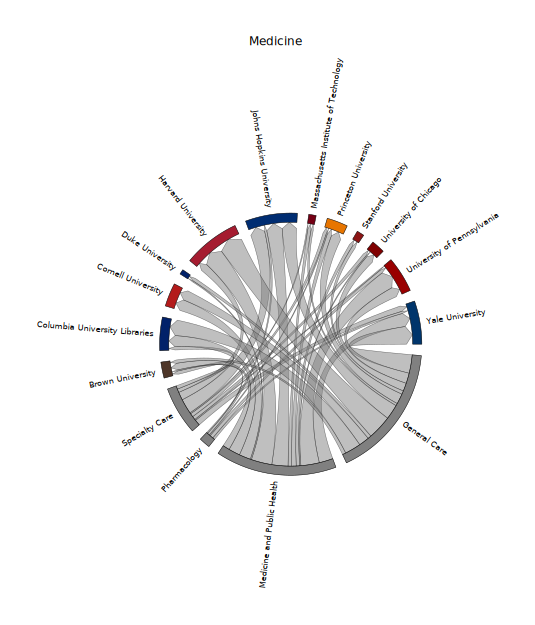

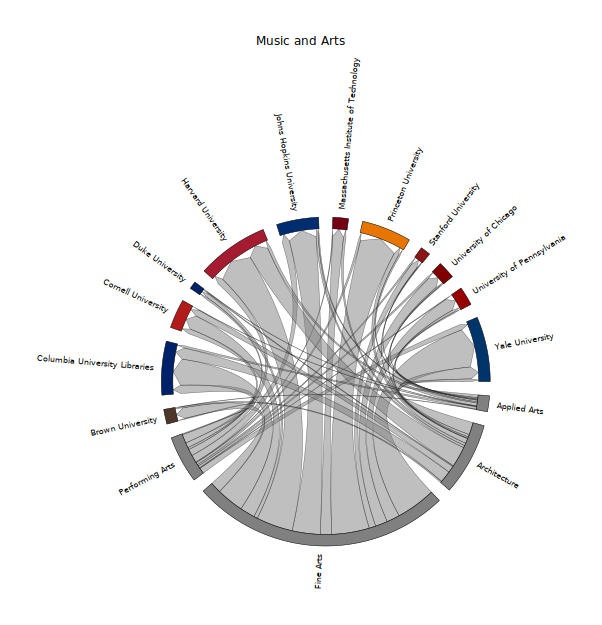

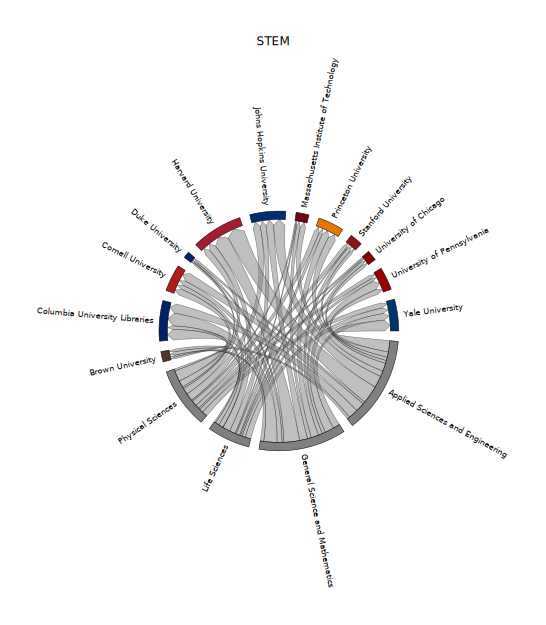

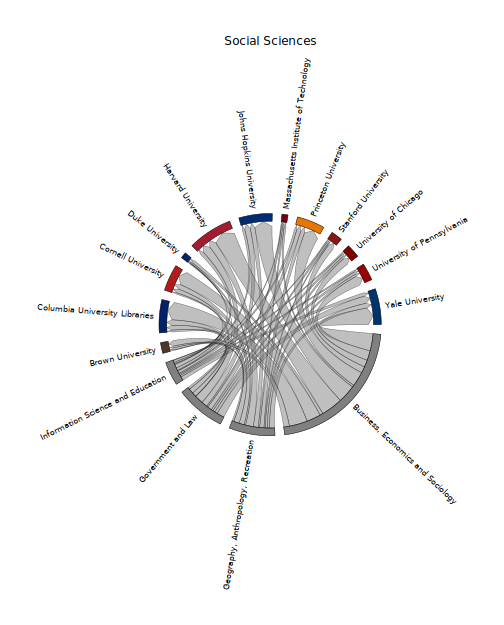

In [48]:
for area, records in lent.groupby("Area"):
    order = sorted(records.From.unique()) + sorted(records.To.unique())
    fig = make_chord(records.drop(columns=["Area", "N", "Rank"]), order=order)
    records.to_csv(f"out/lent-{area}.csv", index=None)
    fig.savefig(f"out/chord-lent-{area}.png", dpi=300)
    fig.suptitle(area)